# [作業目標]
- 使用 Day 12 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 12 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [1]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 設定 data_path
dir_data = './data/'

### 之前做過的處理

In [2]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [4]:
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [6]:
for col in app_train.columns:
    print(col)

SK_ID_CURR
TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
ORGANIZATION_TYPE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APART

In [7]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

condition_col_name=[]

# 檢查每一個 column
for col in app_train.columns:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            condition_col_name.append(col)
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
print(condition_col_name)

['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']


In [9]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 12 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [10]:
# 觀察相關係數
##只显示'TARGET'的series与其他的column之series的相关系数
TARGET_corr=app_train.corr()['TARGET']
TARGET_corr

SK_ID_CURR                    -0.002108
TARGET                         1.000000
NAME_CONTRACT_TYPE            -0.030896
FLAG_OWN_CAR                  -0.021851
FLAG_OWN_REALTY               -0.006148
CNT_CHILDREN                   0.019187
AMT_INCOME_TOTAL              -0.003982
AMT_CREDIT                    -0.030369
AMT_ANNUITY                   -0.012817
AMT_GOODS_PRICE               -0.039645
REGION_POPULATION_RELATIVE    -0.037227
DAYS_BIRTH                    -0.078239
DAYS_EMPLOYED                  0.074958
DAYS_REGISTRATION              0.041975
DAYS_ID_PUBLISH                0.051457
OWN_CAR_AGE                    0.037612
FLAG_MOBIL                     0.000534
FLAG_EMP_PHONE                 0.045982
FLAG_WORK_PHONE                0.028524
FLAG_CONT_MOBILE               0.000370
FLAG_PHONE                    -0.023806
FLAG_EMAIL                    -0.001758
CNT_FAM_MEMBERS                0.009308
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893


In [11]:
#TARGET_corr不是dataframe，因此要改成dataframe
#corrdf = pd.DataFrame(TARGET_corr.values,TARGET_corr.index, columns = ['corr'])
TARGET_corr_df=pd.DataFrame(TARGET_corr.values,TARGET_corr.index, columns = ['corr'])
TARGET_corr_df

,corr
SK_ID_CURR,-0.002108
TARGET,1.000000
NAME_CONTRACT_TYPE,-0.030896
FLAG_OWN_CAR,-0.021851
FLAG_OWN_REALTY,-0.006148
CNT_CHILDREN,0.019187
AMT_INCOME_TOTAL,-0.003982
AMT_CREDIT,-0.030369
AMT_ANNUITY,-0.012817
AMT_GOODS_PRICE,-0.039645


In [12]:
"""
由此可知，與TARGET最有關係的是
DAYS_EMPLOYED -->0.074
 
DAYS_LAST_PHONE_CHANGE-->0.055 
"""

TARGET_corr_df.sort_values(by='corr',ascending=False)

,corr
TARGET,1.000000
DAYS_EMPLOYED,0.074958
REGION_RATING_CLIENT_W_CITY,0.060893
REGION_RATING_CLIENT,0.058899
DAYS_LAST_PHONE_CHANGE,0.055218
DAYS_ID_PUBLISH,0.051457
REG_CITY_NOT_WORK_CITY,0.050994
FLAG_EMP_PHONE,0.045982
REG_CITY_NOT_LIVE_CITY,0.044395
FLAG_DOCUMENT_3,0.044346


In [13]:
"""
DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE與TARGET相關性還滿大的
代表DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE數字越大，TARGET越大(TARGET=1表示有還款困難)
"""
############
"""
TARGET=Target variable (1 - client with payment difficulties: he/she had late payment more than X days 
       TARGET=1代表有還債困難
       
DAYS_EMPLOYED=How many days before the application the person started current employment
       DAYS_EMPLOYED代表申請人在申請貸款幾天前就業
       DAYS_EMPLOYED是小於或等於零的數字，數字越負(越小)，代表申請人就業的日期距離申請貸款日越久遠
DAYS_LAST_PHONE_CHANGE=How many days before application did client change phone
       申請人在申請貸款幾天前換電話
       DAYS_LAST_PHONE_CHANGE是小於或等於零的數字，數字越負(越小)，代表申請人換手機的日期距離申請貸款日越久遠
"""
#######################
"""
EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1這幾根評分的分數與TARGET相關性負的很大
表示EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1越小，TARGET越大(TARGET=1表示有還款困難)
"""

'\nEXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1這幾根評分的分數與TARGET相關性負的很大\n表示EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1越小，TARGET越大(TARGET=1表示有還款困難)\n'

In [18]:
#將資料分組
#討論就業日期與還債困難的關係
group_data = app_train[['TARGET', 'DAYS_EMPLOYED']] # subset
group_data 

,TARGET,DAYS_EMPLOYED
0,1,-637.0
1,0,-1188.0
2,0,-225.0
3,0,-3039.0
4,0,-3038.0
5,0,-1588.0
6,0,-3130.0
7,0,-449.0
8,0,NaN
9,0,-2019.0


In [39]:
#判斷dataframe之中是否有NaN
"""
pd.isnull() 
判断是否有缺失数据 NaN, 为 True 表示缺失数据:
"""
group_data.isnull() 

,TARGET,DAYS_EMPLOYED
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
5,False,False
6,False,False
7,False,False
8,False,True
9,False,False


In [40]:
#相加大於零，表示裡面有人為True(有人是NaN)
group_data.isnull().sum().sum() 

55374

In [17]:
##去除NaN
#[法1]使用pd.dropna() 
"""
pd.dropna() 
如果想直接去掉有 NaN 的行或列, 可以使用 dropna
"""

"""
group_data.dropna(
    axis=0,       # 0: 对row进行操作; 1: 对column进行操作
    how='any',    # 'any': 只要存在 NaN 就 drop 掉; 'all': 必须全部是 NaN 才 drop
    inplace=True  #True代表剩下的dataframe是去除NaN後的結果；
                  #預設值是False，代表會秀出去除NaN的結果，但原本的dataframe不改變
) 
    
group_data

"""


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,TARGET,DAYS_EMPLOYED
0,1,-637.0
1,0,-1188.0
2,0,-225.0
3,0,-3039.0
4,0,-3038.0
5,0,-1588.0
6,0,-3130.0
7,0,-449.0
9,0,-2019.0
10,0,-679.0


In [45]:
group_data['DAYS_EMPLOYED'][8]

nan

In [47]:
group_data['DAYS_EMPLOYED'].dtypes

dtype('float64')

In [48]:
group_data.iloc[8,1] 

nan

In [49]:
"""
此處很奇怪，group_data.iloc[8,1]明明就是NaN
group_data.iloc[8,1]==np.nan的結果應該是True才對
"""
group_data.iloc[8,1]==np.nan

False

In [50]:
group_data.iloc[8,1]==1

False

In [56]:
group_data.iloc[9,1]==-2019.0

True

In [57]:
group_data['DAYS_EMPLOYED'].isnull() 

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8          True
9         False
10        False
11         True
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23         True
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
307481    False
307482    False
307483     True
307484    False
307485    False
307486    False
307487     True
307488    False
307489    False
307490    False
307491    False
307492    False
307493    False
307494    False
307495    False
307496    False
307497    False
307498    False
307499    False
307500    False
307501    False
307502    False
307503    False
307504    False
307505     True
307506    False
307507     True
307508    False
307509    False
307510    False
Name: DAYS_EMPLOYED, Len

In [60]:
list(group_data['DAYS_EMPLOYED'].isnull()) #用list把一連串非矩陣之布林T或F，改成矩陣形式

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 Fa

In [61]:
group_data[list(group_data['DAYS_EMPLOYED'].isnull()) ]  #只剩下是NaN的那些indeX

,TARGET,DAYS_EMPLOYED
8,0,NaN
11,0,NaN
23,0,NaN
38,0,NaN
43,0,NaN
46,0,NaN
54,0,NaN
56,0,NaN
62,0,NaN
79,0,NaN


In [77]:
#這個寫法也可以
#會留下group_data['DAYS_EMPLOYED'].isnull()式子中為True的部分
group_data[group_data['DAYS_EMPLOYED'].isnull()] 

,TARGET,DAYS_EMPLOYED
8,0,NaN
11,0,NaN
23,0,NaN
38,0,NaN
43,0,NaN
46,0,NaN
54,0,NaN
56,0,NaN
62,0,NaN
79,0,NaN


In [78]:
#這個寫法也可以
#會留下group_data['DAYS_EMPLOYED'].isnull()式子中為True的部分
group_data[group_data['DAYS_EMPLOYED'].isnull()==True] 

,TARGET,DAYS_EMPLOYED
8,0,NaN
11,0,NaN
23,0,NaN
38,0,NaN
43,0,NaN
46,0,NaN
54,0,NaN
56,0,NaN
62,0,NaN
79,0,NaN


In [79]:
#會留下group_data['DAYS_EMPLOYED'].isnull()式子中為False的部分
group_data[group_data['DAYS_EMPLOYED'].isnull()==False] 

,TARGET,DAYS_EMPLOYED
0,1,-637.0
1,0,-1188.0
2,0,-225.0
3,0,-3039.0
4,0,-3038.0
5,0,-1588.0
6,0,-3130.0
7,0,-449.0
9,0,-2019.0
10,0,-679.0


In [80]:
#這個寫法也可以
#會留下group_data['DAYS_EMPLOYED'].isnull()式子中為False的部分
group_data[group_data['DAYS_EMPLOYED'].isnull().values==False] 

,TARGET,DAYS_EMPLOYED
0,1,-637.0
1,0,-1188.0
2,0,-225.0
3,0,-3039.0
4,0,-3038.0
5,0,-1588.0
6,0,-3130.0
7,0,-449.0
9,0,-2019.0
10,0,-679.0


In [81]:
group_data_dropNAN=group_data[group_data['DAYS_EMPLOYED'].isnull().values==False] 

In [82]:
group_data_dropNAN

,TARGET,DAYS_EMPLOYED
0,1,-637.0
1,0,-1188.0
2,0,-225.0
3,0,-3039.0
4,0,-3038.0
5,0,-1588.0
6,0,-3130.0
7,0,-449.0
9,0,-2019.0
10,0,-679.0


In [83]:
##bin_cut代表 切 bin_cut 個區間 
#在包含起點與終點情形下，需切出bin_cut+1個點
bin_cut =  10
group_data_dropNAN['DAYS_EMPLOYED2'] = pd.cut(group_data_dropNAN['DAYS_EMPLOYED'], bins = bin_cut) 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [86]:
# 顯示不同組的數量
print(group_data_dropNAN['DAYS_EMPLOYED2'].value_counts())  #計算每個區間的數值個數
group_data_dropNAN.head()

(-1791.2, 0.0]            134392
(-3582.4, -1791.2]         65188
(-5373.6, -3582.4]         27932
(-7164.8, -5373.6]         11382
(-8956.0, -7164.8]          6559
(-10747.2, -8956.0]         3391
(-12538.4, -10747.2]        2027
(-14329.6, -12538.4]         955
(-16120.8, -14329.6]         261
(-17929.912, -16120.8]        50
Name: DAYS_EMPLOYED2, dtype: int64


,TARGET,DAYS_EMPLOYED,DAYS_EMPLOYED2
0,1,-637.0,"(-1791.2, 0.0]"
1,0,-1188.0,"(-1791.2, 0.0]"
2,0,-225.0,"(-1791.2, 0.0]"
3,0,-3039.0,"(-3582.4, -1791.2]"
4,0,-3038.0,"(-3582.4, -1791.2]"


In [87]:
group_sorted_df =  group_data_dropNAN.sort_index(by=['DAYS_EMPLOYED2'])
group_sorted_df 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


,TARGET,DAYS_EMPLOYED,DAYS_EMPLOYED2
227877,0,-16424.0,"(-17929.912, -16120.8]"
62757,0,-16538.0,"(-17929.912, -16120.8]"
204486,0,-16308.0,"(-17929.912, -16120.8]"
298953,0,-16236.0,"(-17929.912, -16120.8]"
280994,0,-17912.0,"(-17929.912, -16120.8]"
253870,0,-16358.0,"(-17929.912, -16120.8]"
65681,0,-16499.0,"(-17929.912, -16120.8]"
145957,0,-16343.0,"(-17929.912, -16120.8]"
280478,0,-16495.0,"(-17929.912, -16120.8]"
117675,0,-16265.0,"(-17929.912, -16120.8]"


In [88]:
#group_sorted_df['DAYS_EMPLOYED2']之下的10種區間範圍
np.unique(group_sorted_df['DAYS_EMPLOYED2']) 

array([Interval(-17929.912, -16120.8, closed='right'),
       Interval(-16120.8, -14329.6, closed='right'),
       Interval(-14329.6, -12538.4, closed='right'),
       Interval(-12538.4, -10747.2, closed='right'),
       Interval(-10747.2, -8956.0, closed='right'),
       Interval(-8956.0, -7164.8, closed='right'),
       Interval(-7164.8, -5373.6, closed='right'),
       Interval(-5373.6, -3582.4, closed='right'),
       Interval(-3582.4, -1791.2, closed='right'),
       Interval(-1791.2, 0.0, closed='right')], dtype=object)

In [90]:
#group_sorted_df['DAYS_EMPLOYED2']之下會是10種區間
#利用==，判斷group_sorted_df['DAYS_EMPLOYED2']之下每一個區間是否會是第0個區間group_sorted[0] 
#結果是一連串的布林T或F
group_sorted=np.unique(group_sorted_df['DAYS_EMPLOYED2']) 
group_sorted_df['DAYS_EMPLOYED2'] == group_sorted[0] 

227877     True
62757      True
204486     True
298953     True
280994     True
253870     True
65681      True
145957     True
280478     True
117675     True
65505      True
218832     True
108004     True
296917     True
121283     True
35191      True
74721      True
269834     True
228384     True
280840     True
226747     True
27064      True
70429      True
230302     True
218503     True
226819     True
40449      True
77348      True
66087      True
241444     True
          ...  
133456    False
133460    False
133462    False
133466    False
133468    False
133469    False
133430    False
133429    False
133428    False
133426    False
133383    False
133387    False
133388    False
133390    False
133391    False
133396    False
133397    False
133398    False
133379    False
133399    False
133402    False
133406    False
133411    False
133412    False
133417    False
133418    False
133420    False
133425    False
133401    False
307510    False
Name: DAYS_EMPLOYED2, Le

In [92]:
#
group_sorted_df =  group_data_dropNAN.sort_index(by=['DAYS_EMPLOYED2'])
group_sorted_name=np.unique(group_sorted_df['DAYS_EMPLOYED2'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  


In [93]:
group_sorted_name

array([Interval(-17929.912, -16120.8, closed='right'),
       Interval(-16120.8, -14329.6, closed='right'),
       Interval(-14329.6, -12538.4, closed='right'),
       Interval(-12538.4, -10747.2, closed='right'),
       Interval(-10747.2, -8956.0, closed='right'),
       Interval(-8956.0, -7164.8, closed='right'),
       Interval(-7164.8, -5373.6, closed='right'),
       Interval(-5373.6, -3582.4, closed='right'),
       Interval(-3582.4, -1791.2, closed='right'),
       Interval(-1791.2, 0.0, closed='right')], dtype=object)

In [98]:
group_sorted_df['DAYS_EMPLOYED2'] == group_sorted_name[0]

227877     True
62757      True
204486     True
298953     True
280994     True
253870     True
65681      True
145957     True
280478     True
117675     True
65505      True
218832     True
108004     True
296917     True
121283     True
35191      True
74721      True
269834     True
228384     True
280840     True
226747     True
27064      True
70429      True
230302     True
218503     True
226819     True
40449      True
77348      True
66087      True
241444     True
          ...  
133456    False
133460    False
133462    False
133466    False
133468    False
133469    False
133430    False
133429    False
133428    False
133426    False
133383    False
133387    False
133388    False
133390    False
133391    False
133396    False
133397    False
133398    False
133379    False
133399    False
133402    False
133406    False
133411    False
133412    False
133417    False
133418    False
133420    False
133425    False
133401    False
307510    False
Name: DAYS_EMPLOYED2, Le

In [102]:
group_sorted_name[0]

Interval(-17929.912, -16120.8, closed='right')

In [103]:
str(group_sorted_name[0])

'(-17929.912, -16120.8]'

In [116]:
i=0
group_sorted_df['DAYS_EMPLOYED2'] == group_sorted_name[i]
a=(group_sorted_df['DAYS_EMPLOYED2'] == group_sorted_name[i])&(group_sorted_df['TARGET'] == 0)
b=group_sorted_df.loc[a, 'DAYS_EMPLOYED2']
b

227877    (-17929.912, -16120.8]
62757     (-17929.912, -16120.8]
204486    (-17929.912, -16120.8]
298953    (-17929.912, -16120.8]
280994    (-17929.912, -16120.8]
253870    (-17929.912, -16120.8]
65681     (-17929.912, -16120.8]
145957    (-17929.912, -16120.8]
280478    (-17929.912, -16120.8]
117675    (-17929.912, -16120.8]
65505     (-17929.912, -16120.8]
218832    (-17929.912, -16120.8]
108004    (-17929.912, -16120.8]
296917    (-17929.912, -16120.8]
121283    (-17929.912, -16120.8]
35191     (-17929.912, -16120.8]
74721     (-17929.912, -16120.8]
269834    (-17929.912, -16120.8]
228384    (-17929.912, -16120.8]
280840    (-17929.912, -16120.8]
226747    (-17929.912, -16120.8]
27064     (-17929.912, -16120.8]
70429     (-17929.912, -16120.8]
230302    (-17929.912, -16120.8]
218503    (-17929.912, -16120.8]
226819    (-17929.912, -16120.8]
40449     (-17929.912, -16120.8]
77348     (-17929.912, -16120.8]
66087     (-17929.912, -16120.8]
241444    (-17929.912, -16120.8]
208899    

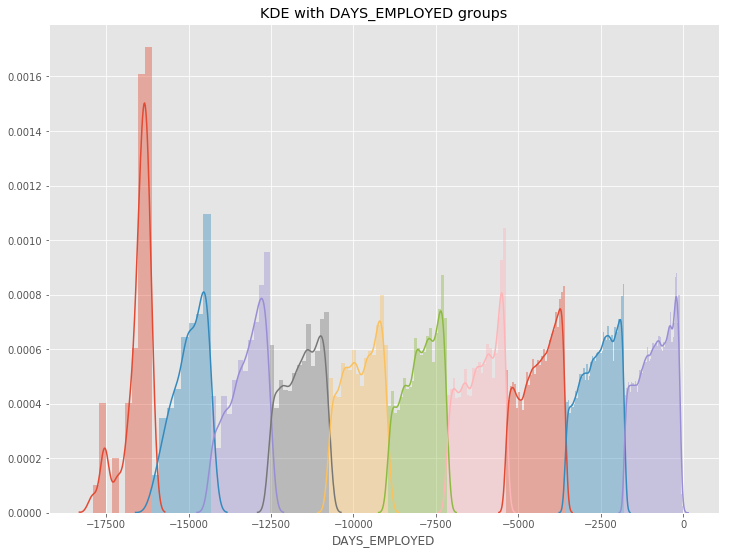

In [118]:
import seaborn as sns # 另一個繪圖-樣式套件
%matplotlib inline
plt.style.use('ggplot')

# 忽略警告訊息
import warnings
warnings.filterwarnings('ignore')


"""
布林數在dataframe.loc[]之中，亦即，
dataframe.df[布林]
會剩下布林數為true的row
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html
"""
plt.figure(figsize=(12,9))
for i in range(len(group_sorted_name)):
    sns.distplot(group_sorted_df.loc[(group_sorted_df['DAYS_EMPLOYED2'] == group_sorted_name[i]) & \
                              (group_sorted_df['TARGET'] == 0), 'DAYS_EMPLOYED'], label = str(group_sorted_name[i])) 
plt.title('KDE with DAYS_EMPLOYED groups')
plt.show()

In [ ]:
##圖形畫出來是一個PDF
#代表TARGET=0(沒有償債風險)時，很多人的DAYS_EMPLOYED是很久遠的
#可以說明，如果一個人的就業日期離申請貸款很久遠，越有可能TARGET=0(沒有償債風險)

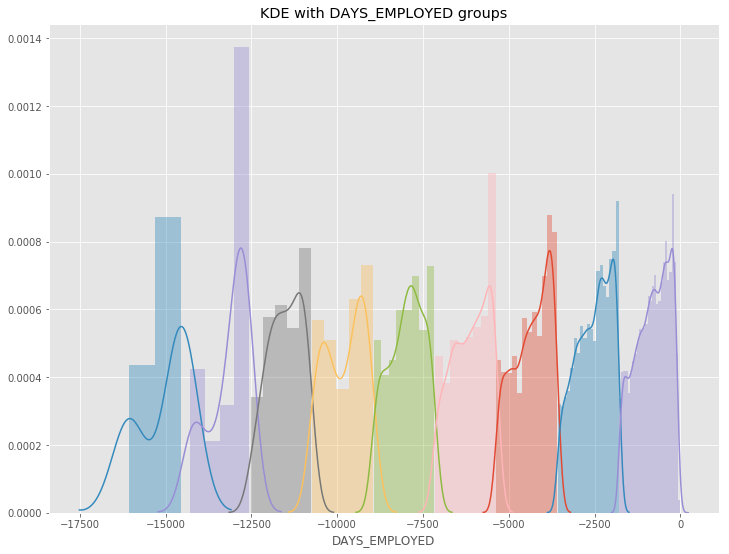

In [119]:
plt.figure(figsize=(12,9))
for i in range(len(group_sorted_name)):
    sns.distplot(group_sorted_df.loc[(group_sorted_df['DAYS_EMPLOYED2'] == group_sorted_name[i]) & \
                              (group_sorted_df['TARGET'] == 1), 'DAYS_EMPLOYED'], label = str(group_sorted_name[i]))
plt.title('KDE with DAYS_EMPLOYED groups')
plt.show()